In [ ]:
!pip install tensorflow-gpu==2.4.0

     |████████████████████████████████| 394.7MB 42kB/s 
     |████████████████████████████████| 3.8MB 42.6MB/s 
     |████████████████████████████████| 2.9MB 31.3MB/s 
     |████████████████████████████████| 471kB 43.9MB/s 
ERROR: tensorflow 2.5.0 has requirement gast==0.4.0, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement grpcio~=1.34.0, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Suc

In [ ]:
from PIL import Image
import random
import warnings
import os
import shutil
from PIL import ImageFile


from tensorflow import keras

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import StratifiedKFold
keras.__version__

'2.4.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/simosista'

training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')
validation_dir = os.path.join(base_dir, 'Validation')

In [ ]:
sourceFiles = []
classLabels = ['Bukan Pelanggaran', 'Pelanggaran']
picture_size = (224, 224)
batch_size = 32
epoch = 5

In [ ]:
def transferBetweenFolders(source, dest, splitRate):
    global sourceFiles
    sourceFiles = os.listdir(source)
    if (len(sourceFiles) != 0):
        transferFileNumbers = int(len(sourceFiles) * splitRate)
        transferIndex = random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source + str(sourceFiles[eachIndex]), dest + str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")


def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(base_dir + '/' + source + '/' + label + '/',
                                base_dir + '/' + dest + '/' + label + '/',
                               splitRate)
        


In [ ]:
# First, check if test folder is empty or not, if not transfer all existing files to train
transferAllClassBetweenFolders('Testing', 'Training', 1.0)
transferAllClassBetweenFolders('Validation', 'Training', 1.0)
# Now, split some part of train data into the test folders.
transferAllClassBetweenFolders('Training', 'Testing', 0.20)

No file moved. Source empty!
No file moved. Source empty!


In [ ]:
X = []
Y = []

def prepareNameWithLabels(folderName):
    sourceFiles = os.listdir(base_dir + '/Training/' + folderName)
    for val in sourceFiles:
         X.append(val)
         if (folderName == classLabels[0]):
             Y.append(0)
         elif (folderName == classLabels[1]):
             Y.append(1)
         else:
             Y.append(2)
             
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
    prepareNameWithLabels(classLabels[i])

X = np.asarray(X)
Y = np.asarray(Y)

In [ ]:
def mobilenetv2():
    base_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                               weights='imagenet',
                                                             input_shape=(224,224,3))

    base_model.trainable = False
    kernel_regulation = keras.regularizers.l2(0.0001)

    x = base_model.output
    # Add some new Fully connected layers to
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)

    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1024, kernel_regularizer=kernel_regulation, activation='relu')(x)
    #x = keras.layers.Dropout(0.2)(x)
    #x = keras.layers.Dense(512, kernel_regularizer=kernel_regulation, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(256, kernel_regularizer=kernel_regulation, activation='relu')(x)
    #x = keras.layers.Dropout(0.2)(x)
    #x = keras.layers.Dense(128, kernel_regularizer=kernel_regulation, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, kernel_regularizer=kernel_regulation, activation='relu')(x)
    #x = keras.layers.Dropout(0.5)(x)
    #x = keras.layers.Dense(32, kernel_regularizer=kernel_regulation, activation='relu')(x)

    output_layer = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.models.Model(inputs=base_model.input,outputs=output_layer)

    for layer in model.layers[:90]:
        layer.trainable=False
    for layer in model.layers[90:]:
        layer.trainable=True

    model.summary()

    learning_rate = 0.0001
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    losses = 'binary_crossentropy'

    model.compile(optimizer=optimizer, loss=losses, metrics=['accuracy'])

    return model

In [ ]:
cnn = mobilenetv2()

filepath = 'best3.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                                 verbose=1, save_weights_only=False,
                                                 save_best_only=True, mode='min')
logdir = 'logs/mobilenet'
tfboard = keras.callbacks.TensorBoard(log_dir=logdir)

callbacks_list = [checkpoint, tfboard]

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

In [ ]:
transferAllClassBetweenFolders('Training', 'Validation', 0.20)
picture_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True)
    
training_set = picture_datagen.flow_from_directory(training_dir,
                                                       shuffle=True,
                                                       target_size=picture_size,
                                                       batch_size=batch_size,
                                                       class_mode='binary')

    # Preprocessing the Test set
test_set = picture_datagen.flow_from_directory(validation_dir,
                                                   shuffle=True,
                                                   target_size=picture_size,
                                                   batch_size=batch_size,
                                                   class_mode='binary')
    
history = cnn.fit(training_set,
                    epochs=10,
                    validation_data=test_set,
                    callbacks=callbacks_list)

Found 1013 images belonging to 2 classes.
Found 568 images belonging to 2 classes.
Epoch 1/10
32/32 [==============================] - 1004s 31s/step - loss: 0.8868 - accuracy: 0.5745 - val_loss: 0.5402 - val_accuracy: 0.8856

Epoch 00001: val_loss improved from inf to 0.54022, saving model to best3.h5
Epoch 2/10
32/32 [==============================] - 58s 2s/step - loss: 0.6309 - accuracy: 0.7529 - val_loss: 0.4041 - val_accuracy: 0.8908

Epoch 00002: val_loss improved from 0.54022 to 0.40408, saving model to best3.h5
Epoch 3/10
32/32 [==============================] - 58s 2s/step - loss: 0.4396 - accuracy: 0.8811 - val_loss: 0.3880 - val_accuracy: 0.9102

Epoch 00003: val_loss improved from 0.40408 to 0.38803, saving model to best3.h5
Epoch 4/10
32/32 [==============================] - 58s 2s/step - loss: 0.3566 - accuracy: 0.9292 - val_loss: 0.3912 - val_accuracy: 0.9155

Epoch 00004: val_loss did not improve from 0.38803
Epoch 5/10
32/32 [==============================] - 58s 2s/s

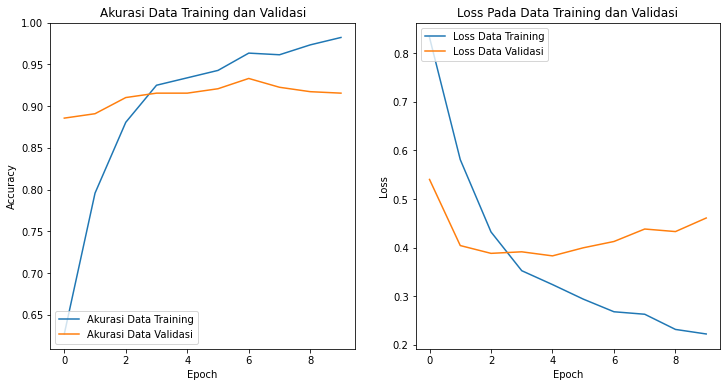

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch = 10

train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(epoch), train_acc, label='Akurasi Data Training')
plt.plot(range(epoch), val_acc, label='Akurasi Data Validasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.title('Akurasi Data Training dan Validasi')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), train_loss, label='Loss Data Training')
plt.plot(range(epoch), val_loss, label='Loss Data Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Loss Pada Data Training dan Validasi')

plt.show()

In [ ]:
# ===============Stratified K-Fold======================
skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(X, Y)
foldNum=0
for train_index, val_index in skf.split(X, Y):
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('Validation', 'Training', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)

    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        if(Y_val[eachIndex]==0):
            classLabel=classLabels[0]
        elif(Y_val[eachIndex]==1):
            classLabel=classLabels[1]
        else:
            classLabel=classLabels[2]
        #Then, copy the validation images to the validation folder
        shutil.move(base_dir+'/Training/'+classLabel+'/'+X_val[eachIndex],
                    base_dir+'/Validation/'+classLabel+'/'+X_val[eachIndex])

    picture_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True)
    
    training_set = picture_datagen.flow_from_directory(training_dir,
                                                       shuffle=True,
                                                       target_size=picture_size,
                                                       batch_size=batch_size,
                                                       class_mode='binary')

    # Preprocessing the Test set
    test_set = picture_datagen.flow_from_directory(validation_dir,
                                                   shuffle=True,
                                                   target_size=picture_size,
                                                   batch_size=batch_size,
                                                   class_mode='binary')


    # Training the CNN on the Training set and evaluating it on the Test set
    fit = cnn.fit(training_set,
                    epochs=epoch,
                    validation_data=test_set,
                  callbacks=callbacks_list)

Results for fold 1
Found 1264 images belonging to 2 classes.
Found 317 images belonging to 2 classes.
Epoch 1/10
40/40 [==============================] - 61s 2s/step - loss: 0.2696 - accuracy: 0.9597 - val_loss: 0.4196 - val_accuracy: 0.9369

Epoch 00001: val_loss did not improve from 0.38283
Epoch 2/10
40/40 [==============================] - 58s 1s/step - loss: 0.2512 - accuracy: 0.9676 - val_loss: 0.4755 - val_accuracy: 0.9211

Epoch 00002: val_loss did not improve from 0.38283
Epoch 3/10
40/40 [==============================] - 58s 1s/step - loss: 0.2236 - accuracy: 0.9786 - val_loss: 0.4453 - val_accuracy: 0.9369

Epoch 00003: val_loss did not improve from 0.38283
Epoch 4/10
40/40 [==============================] - 58s 1s/step - loss: 0.2155 - accuracy: 0.9818 - val_loss: 0.4021 - val_accuracy: 0.9401

Epoch 00004: val_loss did not improve from 0.38283
Epoch 5/10
40/40 [==============================] - 58s 1s/step - loss: 0.1883 - accuracy: 0.9929 - val_loss: 0.4081 - val_accurac

In [ ]:
modelpath = 'best2.h5'
cnn.save(modelpath)

Saving 273275,3e40e000c18a95a6.jpg to 273275,3e40e000c18a95a6.jpg
[[6.864101e-05]]
[[0.06864101]]
Bukan Pelanggaran


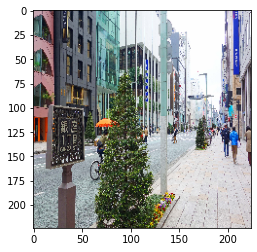

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for uploaded_file in uploaded.keys():
  img = image.load_img(uploaded_file, target_size=(224,224))
  imgplot = plt.imshow(img)
  img_arr = image.img_to_array(img)
  x = np.expand_dims(img_arr, axis=0)

  images = np.vstack([x])
  classes = cnn.predict(images, batch_size=4)

  print(classes)

  threshold = 0.0005
  print(classes)
  if(classes < threshold):
    print(classLabels[0])
  else:
    print(classLabels[1])

  

Saving 273271,1c3c10003afd20b9.jpg to 273271,1c3c10003afd20b9.jpg
[[0.16775845]]
[[167.75845]]
Pelanggaran


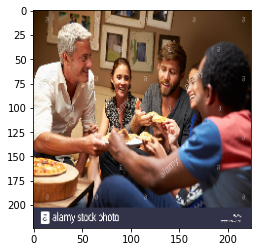

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for uploaded_file in uploaded.keys():
  img = image.load_img(uploaded_file, target_size=(224,224))
  imgplot = plt.imshow(img)
  img_arr = image.img_to_array(img)
  x = np.expand_dims(img_arr, axis=0)

  images = np.vstack([x])
  classes = cnn.predict(images, batch_size=4)

  print(classes)

  threshold = 0.0005
  print(classes)
  if(classes < threshold):
    print(classLabels[0])
  else:
    print(classLabels[1])